# Introduction to Mixture Density Networks

This notebook demonstrates how to optimize a Mixture Density Networks PyTorch model using the TorchNaut library. In this "Bring Your Own Model" example, we'll use a simple feedforward neural network and train it to minimize the Negative Log-Likelihood loss function. The notebook covers data loading, preprocessing, model definition, training loop, and evaluation, showcasing how TorchNaut simplifies the process of probabilistic forecasting with PyTorch.

# Imports, loading and splitting data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from torchnaut import mdn, utils, kde, crps
from torchnaut.utils import LabelScaler

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
data = load_diabetes()
X, y = data.data, data.target.reshape(-1, 1) # Note: reshape y to 2D.

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessing

In [2]:
# Standardize features using training data only
scaler_X = StandardScaler().fit(X_train)
X_train = scaler_X.transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# The utils.LabelScaler class provides a convenient way to standardize targets, with the ability to
# also inverse transform tensors of shape [batch_size, n_samples, n_features]
scaler_y = LabelScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model and optimizer

In [3]:
# Define a simple neural network
class MDNModel(nn.Module):
    def __init__(self, input_dim, n_components=100):
        super().__init__()
        self.mdn = mdn.MDN(n_components=n_components) # Helper class
        self.layers = nn.ModuleList([
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, self.mdn.network_output_dim), # MDN output parameters
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Initialize model and optimizer
model = MDNModel(input_dim=X.shape[1]).to(device)
# Lower learning rate for MDN than for CRPS
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5)

# Training

In [4]:
# Training loop with validation
epochs = 100
best_val_loss = np.inf
best_model = None
patience = 0
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        # It is important to squeeze the batch_y tensor to remove the extra dimension
        nll = (-1) * model.mdn.get_dist(outputs).log_prob(batch_y.squeeze())
        # We need to clamp the NLL during training to avoid numerical issues
        loss = torch.clamp(nll, min=-20).mean()
        loss.backward()
        # Grad clipping is often also important for MDN training
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()
        train_loss += loss.item()
    scheduler.step()

    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            outputs_scaled = model.mdn.inverse_transform(outputs, scaler_y).squeeze()
            nll = (-1) * model.mdn.get_dist(outputs_scaled).log_prob(batch_y.squeeze())
            val_losses.append(nll.cpu().numpy())
        val_loss = np.concatenate(val_losses).mean()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val NLL: {val_loss:.4f}")
    if best_val_loss > val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        patience = 0
    else:
        patience += 1
        if patience >= 9:
            print("Early stopping!")
            model.load_state_dict(best_model)
            break

Epoch [1/100], Train Loss: 1.6146, Val NLL: 10.7303
Epoch [2/100], Train Loss: 1.5662, Val NLL: 10.6432
Epoch [3/100], Train Loss: 1.5743, Val NLL: 10.5411
Epoch [4/100], Train Loss: 1.5602, Val NLL: 10.3858
Epoch [5/100], Train Loss: 1.5417, Val NLL: 10.1035
Epoch [6/100], Train Loss: 1.5326, Val NLL: 9.7938
Epoch [7/100], Train Loss: 1.5377, Val NLL: 9.4306
Epoch [8/100], Train Loss: 1.5513, Val NLL: 9.0276
Epoch [9/100], Train Loss: 1.4810, Val NLL: 8.6328
Epoch [10/100], Train Loss: 1.4604, Val NLL: 8.3067
Epoch [11/100], Train Loss: 1.4369, Val NLL: 7.9431
Epoch [12/100], Train Loss: 1.4161, Val NLL: 7.6571
Epoch [13/100], Train Loss: 1.4148, Val NLL: 7.3625
Epoch [14/100], Train Loss: 1.3539, Val NLL: 7.1199
Epoch [15/100], Train Loss: 1.3244, Val NLL: 6.9097
Epoch [16/100], Train Loss: 1.3188, Val NLL: 6.7217
Epoch [17/100], Train Loss: 1.2935, Val NLL: 6.5840
Epoch [18/100], Train Loss: 1.2677, Val NLL: 6.4582
Epoch [19/100], Train Loss: 1.2497, Val NLL: 6.3908
Epoch [20/100], 

# Testing

In [5]:
# Marginal estimates are predictions that are unconditional on the input.
# For regression, the marginal point prediction is the mean of the training targets, essentially
# resulting in the RMSE estimating the standard deviation of the target distribution. Analogously,
# the marginal distribution is a constant distribution, which provides a useful reference point
# for interpreting CRPS/NLL scores.
marginal_point_pred = X_train_tensor.mean()
marginal_dist_pred = torch.tensor(y_train).T.to(device)

model.eval()
test_crps = []
test_rmse = []
test_nll = []
marginal_crps = []
marginal_nll = []
all_outputs = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        outputs_scaled = model.mdn.inverse_transform(outputs, scaler_y).squeeze()
        # torch produces samples as [n_samples, batch_size], so we transpose
        samples = model.mdn.get_dist(outputs_scaled).sample((1000,)).T

        # CRPS still calculated based on samples
        crps_loss = crps.crps_loss(samples, batch_y)
        test_crps.append(crps_loss.cpu().numpy())
        marginal_crps_loss = crps.crps_loss(marginal_dist_pred.repeat(batch_y.shape[0], 1), batch_y).cpu()
        marginal_crps.append(marginal_crps_loss)

        # NLL and the mean are calculated analytically
        pred_mean = model.mdn.get_dist(outputs_scaled).mean
        test_rmse.append(((pred_mean - batch_y.squeeze()) ** 2).cpu().numpy())
        nll = (-1) * model.mdn.get_dist(outputs_scaled).log_prob(batch_y.squeeze())
        test_nll.append(nll.cpu().numpy())

        # Calculate marginal NLLs using KDE
        with torch.device(outputs.device):
            mnll = kde.nll_gpu(marginal_dist_pred.repeat(batch_y.shape[0], 1), batch_y)
            marginal_nll.append(mnll.cpu().numpy())

        # Save all outputs for calibration plotting later
        all_outputs.append(samples.cpu().numpy())

    test_crps = np.concatenate(test_crps).mean()
    test_nll = np.concatenate(test_nll).mean()
    test_rmse = np.sqrt(np.concatenate(test_rmse).mean())
    test_crps_marginal = np.concatenate(marginal_crps).mean()
    test_nll_marginal = np.concatenate(marginal_nll).mean()
    all_outputs = np.concatenate(all_outputs, axis=0)

print(f"Test CRPS: {test_crps:.4f} (marginal: {test_crps_marginal:.4f})")
print(f"Test NLL: {test_nll:.4f} (marginal: {test_nll_marginal:.4f})")
print(f"Test RMSE: {test_rmse:.4f} (marginal: {((y_test_tensor-marginal_point_pred)**2).mean()**(1/2):.4f})")

Test CRPS: 36.5906 (marginal: 43.0078)
Test NLL: 7.6106 (marginal: 5.6368)
Test RMSE: 57.2137 (marginal: 166.5705)


On this dataset, the marginal KDE performs better than MDN! However, this is not true in general,
as MDN is usually a quite strong model

## Plotting densities

In [6]:
# Predictions for the first batch of the test set
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X).cpu()
        outputs_scaled = model.mdn.inverse_transform(outputs, scaler_y).squeeze()
        break

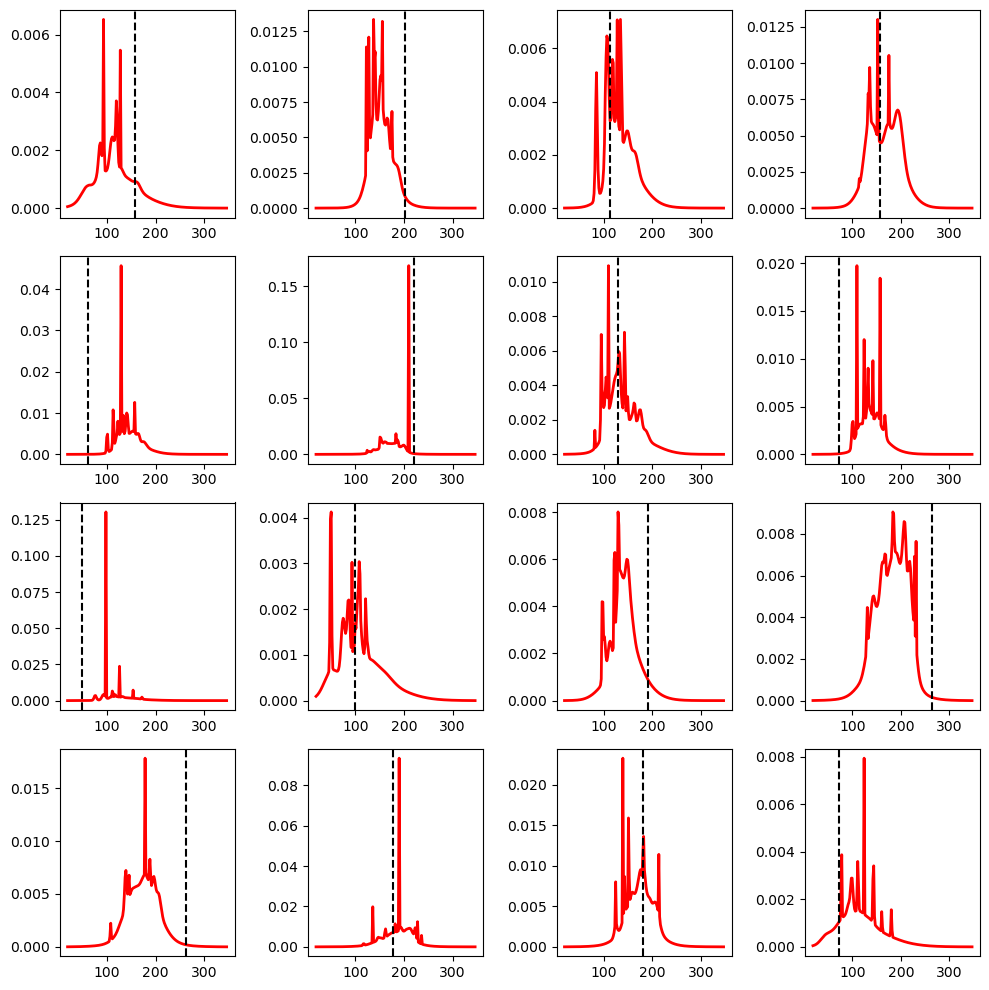

In [7]:
# Get KDE distributions. Returns a list of PyTorch MixtureSameFamily distributions.
samples = model.mdn.get_dist(outputs_scaled).sample((1000,)).T
# kde_dists = model.mdn.get_dist(outputs_scaled)

# Create evaluation points for density plotting
x_range = np.linspace(samples.min().item(), samples.max().item(), 200)
x_eval = torch.tensor(x_range).float()

fig, _ = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, (preds, y) in enumerate(zip(outputs_scaled, batch_y)):
    dist = model.mdn.get_dist(preds.unsqueeze(0))
    plt.subplot(4, 4, i+1)
    density = torch.exp(dist.log_prob(x_eval))
    plt.plot(x_range, density.cpu().numpy(), 'r-', lw=2)
    plt.axvline(y, color="black", linestyle='--')
plt.tight_layout()

# Plotting calibration curve

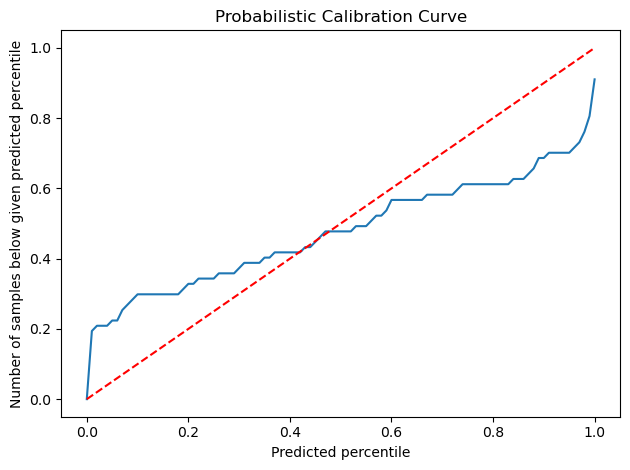

In [8]:
ref_percentiles, cumulative_percentiles = utils.calculate_pit_cdf(all_outputs, y_test)

# Plot probabilistic calibration curve (PIT CDF) against the reference line
plt.title("Probabilistic Calibration Curve")
plt.plot(ref_percentiles, cumulative_percentiles)
plt.plot(ref_percentiles, ref_percentiles, c="r", linestyle='--')
plt.ylabel("Number of samples below given predicted percentile")
plt.xlabel("Predicted percentile")
plt.tight_layout()